# TSLA Close Price Prediction (Simple RNN)

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)
tf.random.set_seed(42)

data_path = Path("TSLA.csv")
window_size = 30
batch_size = 64
max_epochs = 80
val_days_per_month = 2
test_days_per_month = 2


In [50]:
df = pd.read_csv(data_path, parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)
display(df.head())
print(f"Total rows: {len(df)}")


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


Total rows: 2956


In [51]:
features = df[["Open", "High", "Low"]].to_numpy(dtype=np.float32)
targets = df[["Close"]].to_numpy(dtype=np.float32)
dates = df["Date"].to_numpy()
features[:3], targets[:3]


(array([[3.8  , 5.   , 3.508],
        [5.158, 6.084, 4.66 ],
        [5.   , 5.184, 4.054]], dtype=float32),
 array([[4.778],
        [4.766],
        [4.392]], dtype=float32))

In [52]:
def calendar_split_indices(dates, val_days=2, test_days=2):
    dates = pd.to_datetime(dates)
    date_series = pd.Series(dates)
    grouped = date_series.groupby([date_series.dt.year, date_series.dt.month], sort=True)

    train_idx, val_idx, test_idx = [], [], []
    for _, month_indices in grouped.groups.items():
        idx_sorted = np.sort(month_indices)
        n = len(idx_sorted)
        if n == 0:
            continue

        test_count = min(test_days, n)
        remaining = n - test_count
        val_count = min(val_days, remaining)
        train_count = max(remaining - val_count, 0)

        if train_count > 0:
            train_idx.extend(idx_sorted[:train_count])
        if val_count > 0:
            val_start = train_count
            val_idx.extend(idx_sorted[val_start : val_start + val_count])
        if test_count > 0:
            test_idx.extend(idx_sorted[-test_count:])

    return (
        np.array(sorted(train_idx), dtype=int),
        np.array(sorted(val_idx), dtype=int),
        np.array(sorted(test_idx), dtype=int),
    )


def build_sequences(features, targets, dates, window_size):
    if len(features) < window_size:
        raise ValueError(
            "Not enough samples ({}) to build sequences with window size {}.".format(len(features), window_size)
        )

    sequence_features = []
    sequence_targets = []
    sequence_dates = []
    sequence_indices = []
    for end_idx in range(window_size - 1, len(features)):
        start_idx = end_idx - window_size + 1
        sequence_features.append(features[start_idx : end_idx + 1])
        sequence_targets.append(targets[end_idx])
        sequence_dates.append(dates[end_idx])
        sequence_indices.append(end_idx)

    return (
        np.stack(sequence_features).astype(np.float32),
        np.stack(sequence_targets).astype(np.float32),
        np.array(sequence_dates),
        np.array(sequence_indices, dtype=int),
    )


def prepare_datasets(features, targets, dates, window_size, val_days=2, test_days=2):
    train_idx, val_idx, test_idx = calendar_split_indices(dates, val_days=val_days, test_days=test_days)
    if len(train_idx) == 0:
        raise ValueError("No training samples identified. Adjust the split configuration.")

    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    feature_scaler.fit(features[train_idx])
    target_scaler.fit(targets[train_idx])

    scaled_features = feature_scaler.transform(features)
    scaled_targets = target_scaler.transform(targets)

    (
        all_x,
        all_y,
        all_dates,
        sample_indices,
    ) = build_sequences(scaled_features, scaled_targets, dates, window_size)

    train_mask = np.isin(sample_indices, train_idx)
    val_mask = np.isin(sample_indices, val_idx)
    test_mask = np.isin(sample_indices, test_idx)

    split_counts = {
        "train": int(train_mask.sum()),
        "val": int(val_mask.sum()),
        "test": int(test_mask.sum()),
    }

    if split_counts["train"] == 0:
        raise ValueError(
            "No training sequences available. Try reducing window_size or adjusting the monthly hold-out configuration."
        )

    train = (all_x[train_mask], all_y[train_mask], all_dates[train_mask])
    val = (all_x[val_mask], all_y[val_mask], all_dates[val_mask])
    test = (all_x[test_mask], all_y[test_mask], all_dates[test_mask])

    split_info = {
        "train_indices": train_idx,
        "val_indices": val_idx,
        "test_indices": test_idx,
        "sample_indices": sample_indices,
        "counts": split_counts,
    }

    return train, val, test, target_scaler, split_info


In [53]:
(
    train_data,
    val_data,
    test_data,
    target_scaler,
    split_info,
) = prepare_datasets(
    features,
    targets,
    dates,
    window_size,
    val_days=val_days_per_month,
    test_days=test_days_per_month,
)

x_train, y_train, train_dates = train_data
x_val, y_val, val_dates = val_data
x_test, y_test, test_dates = test_data

counts = split_info["counts"]
print(
    f"Sequence counts → train: {counts['train']}, val: {counts['val']}, test: {counts['test']}"
)
print(
    f"Targets shapes: train {y_train.shape}, val {y_val.shape}, test {y_test.shape}"
)
print(
    "Close range seen during training: "
    f"{target_scaler.data_min_[0]:.2f} → {target_scaler.data_max_[0]:.2f} (USD)"
)


Sequence counts → train: 2367, val: 280, test: 280
Targets shapes: train (2367, 1), val (280, 1), test (280, 1)
Close range seen during training: 3.16 → 1229.91 (USD)


In [54]:
actuals = target_scaler.inverse_transform(y_test)


def build_rnn_model(input_shape):
    model = Sequential(
        [
            Input(shape=input_shape),
            SimpleRNN(64, return_sequences=True),
            Dropout(0.2),
            SimpleRNN(32),
            Dense(32, activation="relu"),
            Dense(1),
        ]
    )
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    return model


def build_lstm_model(input_shape):
    model = Sequential(
        [
            Input(shape=input_shape),
            LSTM(64, return_sequences=True),
            Dropout(0.2),
            LSTM(32),
            Dense(32, activation="relu"),
            Dense(1),
        ]
    )
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    return model


def train_and_evaluate(builder, model_name):
    model = builder((window_size, x_train.shape[-1]))
    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        verbose=1,
    )
    history = model.fit(
        x_train,
        y_train,
        validation_data=(x_val, y_val),
        epochs=max_epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=2,
    )
    scaled_predictions = model.predict(x_test)
    predictions = target_scaler.inverse_transform(scaled_predictions)
    mse_value = mean_squared_error(actuals, predictions)
    return {
        "name": model_name,
        "model": model,
        "history": history,
        "predictions": predictions,
        "mse": mse_value,
    }


results = []


In [55]:
for model_name, builder in [
    ("SimpleRNN", build_rnn_model),
    ("LSTM", build_lstm_model),
]:
    print(f"\nTraining {model_name}...")
    result = train_and_evaluate(builder, model_name)
    results.append(result)
    print(f"{model_name} Test MSE: {result['mse']:.4f}")



Training SimpleRNN...
Epoch 1/80
37/37 - 2s - 44ms/step - loss: 0.0152 - val_loss: 6.3116e-04
Epoch 2/80
37/37 - 0s - 6ms/step - loss: 0.0019 - val_loss: 5.3907e-04
Epoch 3/80
37/37 - 0s - 6ms/step - loss: 0.0012 - val_loss: 3.5775e-04
Epoch 4/80
37/37 - 0s - 6ms/step - loss: 8.6225e-04 - val_loss: 3.0065e-04
Epoch 5/80
37/37 - 0s - 6ms/step - loss: 8.1770e-04 - val_loss: 3.1602e-04
Epoch 6/80
37/37 - 0s - 6ms/step - loss: 7.3092e-04 - val_loss: 3.5104e-04
Epoch 7/80
37/37 - 0s - 6ms/step - loss: 5.4909e-04 - val_loss: 2.6877e-04
Epoch 8/80
37/37 - 0s - 5ms/step - loss: 4.4900e-04 - val_loss: 1.7690e-04
Epoch 9/80
37/37 - 0s - 6ms/step - loss: 4.3793e-04 - val_loss: 2.5450e-04
Epoch 10/80
37/37 - 0s - 6ms/step - loss: 4.1111e-04 - val_loss: 2.0035e-04
Epoch 11/80
37/37 - 0s - 6ms/step - loss: 4.0451e-04 - val_loss: 1.8578e-04
Epoch 12/80
37/37 - 0s - 5ms/step - loss: 3.6371e-04 - val_loss: 1.8280e-04
Epoch 13/80
37/37 - 0s - 5ms/step - loss: 3.4085e-04 - val_loss: 1.7972e-04
Epoch 14/

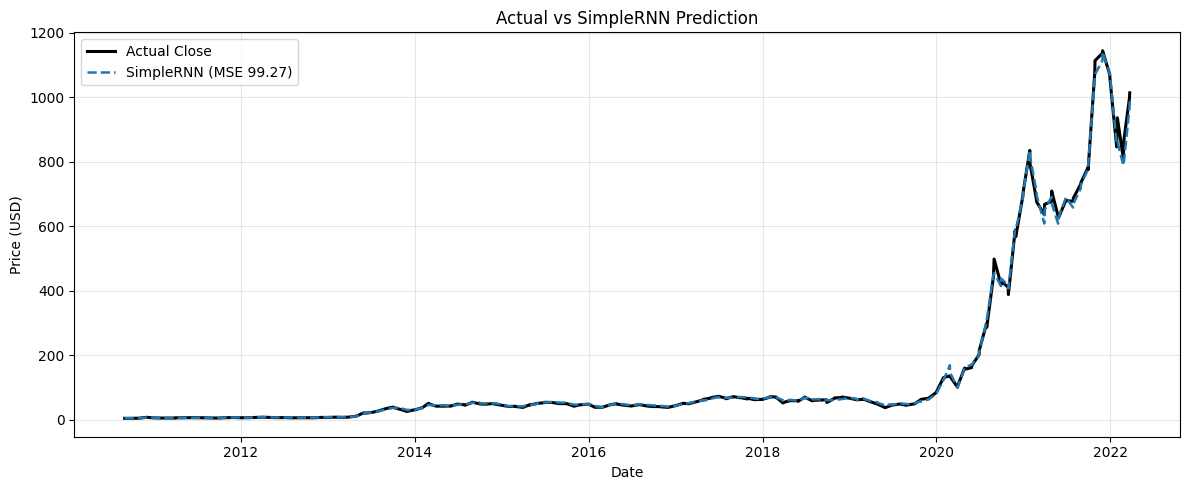

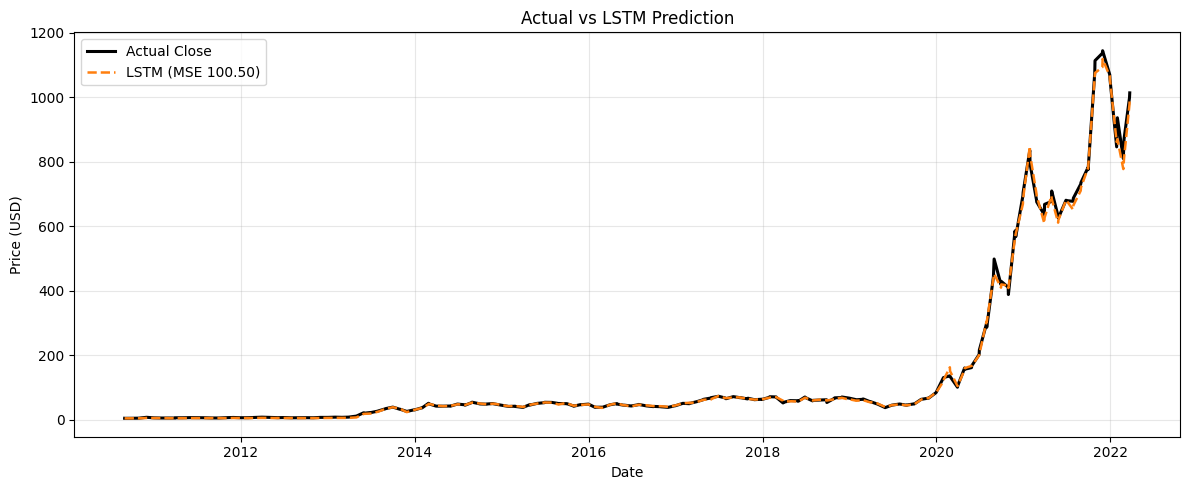

SimpleRNN Test MSE: 99.2660
LSTM Test MSE: 100.5013


In [56]:
actual_series = actuals.flatten()

result_lookup = {res["name"]: res for res in results}
rnn_res = result_lookup.get("SimpleRNN")
lstm_res = result_lookup.get("LSTM")

if rnn_res is None or lstm_res is None:
    raise ValueError("Both SimpleRNN and LSTM results must be available for plotting.")

plt.figure(figsize=(12, 5))
plt.plot(test_dates, actual_series, label="Actual Close", linewidth=2.2, color="black")
plt.plot(
    test_dates,
    rnn_res["predictions"].flatten(),
    label=f"SimpleRNN (MSE {rnn_res['mse']:.2f})",
    linewidth=1.8,
    linestyle="--",
    color="tab:blue",
)
plt.title("Actual vs SimpleRNN Prediction")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(test_dates, actual_series, label="Actual Close", linewidth=2.2, color="black")
plt.plot(
    test_dates,
    lstm_res["predictions"].flatten(),
    label=f"LSTM (MSE {lstm_res['mse']:.2f})",
    linewidth=1.8,
    linestyle="--",
    color="tab:orange",
)
plt.title("Actual vs LSTM Prediction")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"SimpleRNN Test MSE: {rnn_res['mse']:.4f}")
print(f"LSTM Test MSE: {lstm_res['mse']:.4f}")


In [57]:
comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual_Close": actuals.flatten(),
})
for res in results:
    comparison_df[f"{res['name']}_Predicted"] = res["predictions"].flatten()

comparison_df.tail()


,Date,Actual_Close,SimpleRNN_Predicted,LSTM_Predicted
275,2022-01-31,936.719971,863.368591,870.552795
276,2022-02-25,809.869995,788.630554,777.431335
277,2022-02-28,870.429993,802.560913,810.825256
278,2022-03-23,999.109924,967.945618,979.003113
279,2022-03-24,1013.919983,987.728149,999.105713
